In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import gc
from itertools import combinations
import warnings
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from warnings import simplefilter
import joblib
import os
import matplotlib.pyplot as plot
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

is_train = False
is_infer = True

train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
median_sizes = train.groupby('stock_id')['bid_size'].median() + train.groupby('stock_id')['ask_size'].median()
std_sizes = train.groupby('stock_id')['bid_size'].std() + train.groupby('stock_id')['ask_size'].std()
train = train.dropna(subset=['target'])

In [3]:
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [4]:
train.corr()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
stock_id,1.000000,0.005023,0.000002,0.024639,0.004066,-0.000752,0.035130,-0.000831,0.004736,0.004324,0.032982,-0.006342,0.027156,-0.000629,0.000130,0.005023,0.568940
date_id,0.005023,1.000000,-0.000006,0.006441,-0.010572,-0.006456,0.000525,-0.003004,-0.016150,-0.006528,0.024778,-0.006917,0.018675,-0.006839,0.000893,0.999998,0.446692
seconds_in_bucket,0.000002,-0.000006,1.000000,-0.123946,-0.003635,-0.000835,0.068625,-0.000550,0.017627,0.014819,0.162867,-0.017826,0.146337,-0.001259,-0.002203,0.002078,0.218798
imbalance_size,0.024639,0.006441,-0.123946,1.000000,-0.010159,-0.003717,0.512367,0.000523,-0.030932,0.005691,0.021141,-0.012774,0.022623,-0.003495,-0.001190,0.006183,-0.005419
imbalance_buy_sell_flag,0.004066,-0.010572,-0.003635,-0.010159,1.000000,0.182100,-0.006003,0.018010,0.508853,0.129579,0.035238,0.132520,-0.013352,0.133823,0.015102,-0.010580,0.001548
reference_price,-0.000752,-0.006456,-0.000835,-0.003717,0.182100,1.000000,0.007724,0.015349,0.473595,0.983646,0.007271,0.985068,-0.006528,0.988113,-0.017394,-0.006458,-0.006632
matched_size,0.035130,0.000525,0.068625,0.512367,-0.006003,0.007724,1.000000,-0.000705,-0.002722,0.023564,0.078554,-0.007270,0.079209,0.008281,0.000197,0.000668,0.037265
far_price,-0.000831,-0.003004,-0.000550,0.000523,0.018010,0.015349,-0.000705,1.000000,0.031519,0.014327,0.002229,0.014671,-0.000153,0.014643,-0.001804,-0.003005,-0.001236
near_price,0.004736,-0.016150,0.017627,-0.030932,0.508853,0.473595,-0.002722,0.031519,1.000000,0.458373,0.032190,0.460380,-0.013298,0.462579,0.006045,-0.016133,-0.005470
bid_price,0.004324,-0.006528,0.014819,0.005691,0.129579,0.983646,0.023564,0.014327,0.458373,1.000000,-0.001098,0.972906,-0.008456,0.989277,-0.022326,-0.006497,0.000849


Text(0.5, 1.0, 'Correlation Heatmap')

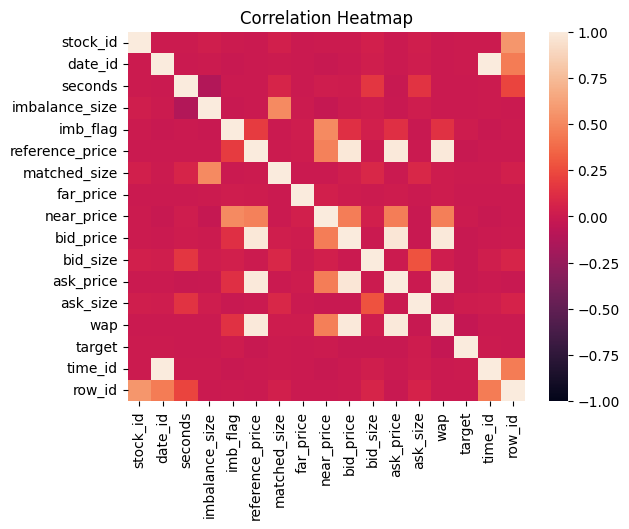

In [5]:
train_rename = train.rename(columns={"seconds_in_bucket": "seconds", "imbalance_buy_sell_flag": "imb_flag"})
_= sns.heatmap(train_rename.corr(),vmin=-1, vmax=1)
plot.title("Correlation Heatmap")

### What is the order of the data

In total, training data has 
- stocks (stock_id): 0,1,2,3,...,198,199
- date (date_id): 0,1,2,...,479, 480
- seconds in a day (seconds_in_bucket): 0,10,20,30,...,530,540

The data is arranged in this way: (date, seconds, stock), in one day, the number of seconds is fixed 
but the number of stock is various during a certain 10 seconds in a certain day.

For example, the first 10505 samples has `data_id=0` and there are 191 stocks in each 10 second.


max value: 199, min value: 0


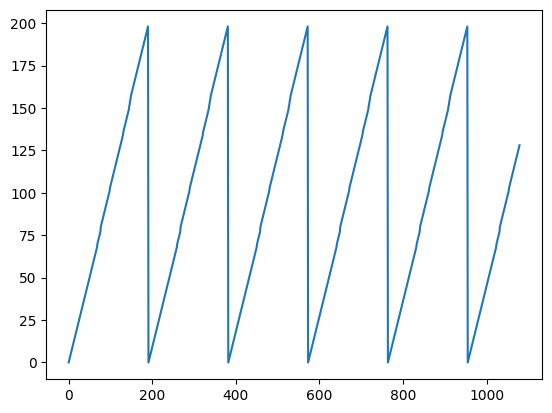

In [6]:
stock_id = train["stock_id"]
plot.plot(stock_id[:1080])
print(f"max value: {stock_id.max()}, min value: {stock_id.min()}")

Text(0, 0.5, 'Stock Id')

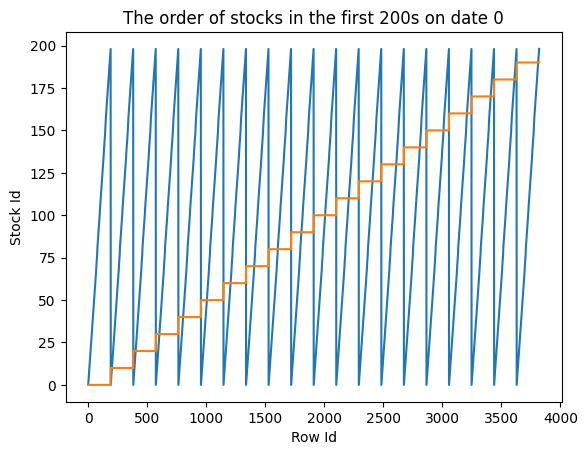

In [7]:
data_ids = train.groupby(["date_id"])
data_id1 = data_ids.get_group(0)
n = 191*20
plot.plot(data_id1["stock_id"][:n])
plot.plot(data_id1["seconds_in_bucket"][:n])
plot.title("The order of stocks in the first 200s on date 0")
plot.xlabel("Row Id")
plot.ylabel("Stock Id")

True
max value: 480, min value: 0
The number of samples of each date_id:
369380
[35]
Unique number of samples {10560, 10529, 10945, 10725, 10505, 10890, 10670, 10835, 10999, 11000, 10780}


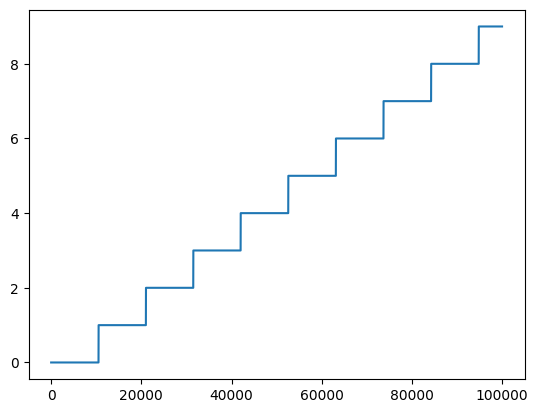

In [8]:
date_id = train["date_id"]
print(date_id.is_monotonic_increasing)
print(f"max value: {date_id.max()}, min value: {date_id.min()}")

data_id_count = train.groupby(["date_id"])["date_id"].count()
print("The number of samples of each date_id:")
print(data_id_count[:35].sum())
print(data_id_count[data_id_count == 10529].index.tolist())
print(f"Unique number of samples {set(train.groupby(['date_id'])['date_id'].count())}")


plot.plot(date_id[:100000])
plot.show()

max value: 540, min value: 0
Each step in the figure has {192, 191} samples


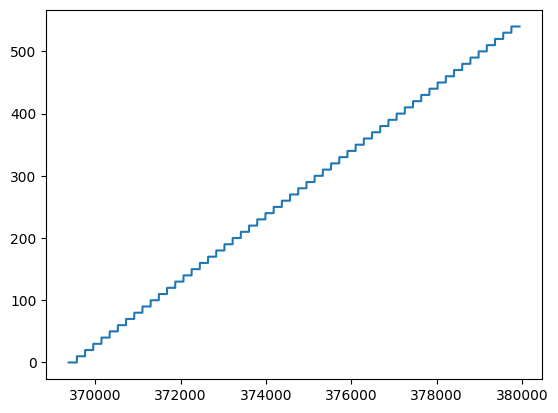

In [9]:
seconds_in_bucket = train["seconds_in_bucket"]
plot.plot(seconds_in_bucket[369380:369380 + 10529])
print(f"max value: {seconds_in_bucket.max()}, min value: {seconds_in_bucket.min()}")
print(f"Each step in the figure has {set(train.iloc[369380:369380 + 10529].groupby(['seconds_in_bucket'])['seconds_in_bucket'].count())} samples")

max value: 2982027811.68, min value: 0.0


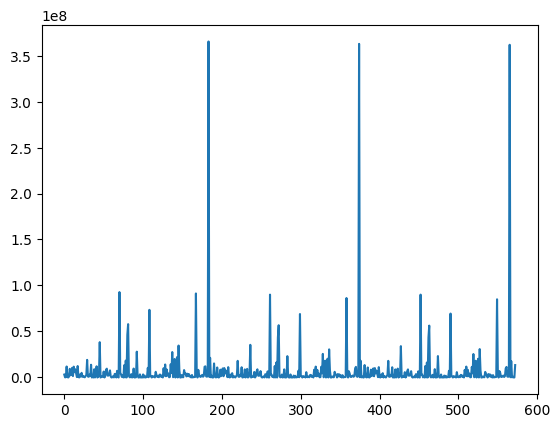

In [10]:
imbalance_size = train["imbalance_size"]
plot.plot(imbalance_size[:573])
print(f"max value: {imbalance_size.max()}, min value: {imbalance_size.min()}")

max value: 1, min value: -1


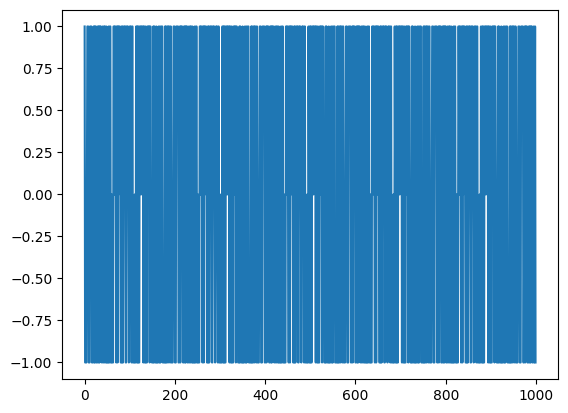

In [11]:
imbalance_flag = train["imbalance_buy_sell_flag"]
plot.plot(imbalance_flag[:1000])
print(f"max value: {imbalance_flag.max()}, min value: {imbalance_flag.min()}")

max value: 1.077488, min value: 0.935285


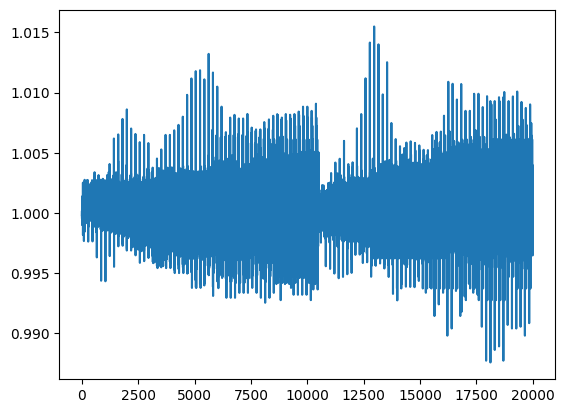

In [12]:
reference_price = train["reference_price"]
plot.plot(reference_price[:20000])
print(f"max value: {reference_price.max()}, min value: {reference_price.min()}")

max value: 7713682054.05, min value: 4316.61


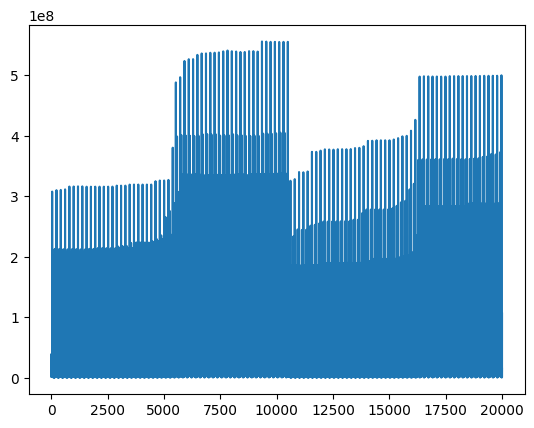

In [13]:
matched_size = train["matched_size"]
plot.plot(matched_size[:20000])
print(f"max value: {matched_size.max()}, min value: {matched_size.min()}")

max value: 437.9531, min value: 7.7e-05


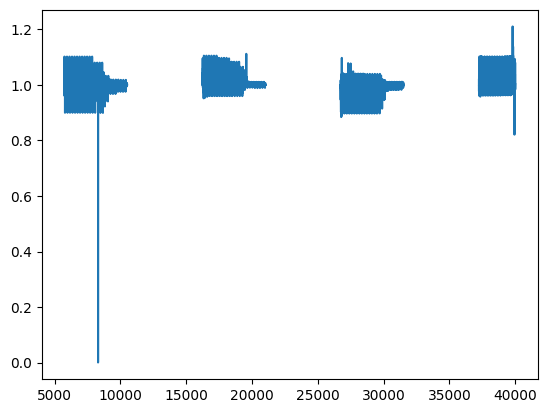

In [14]:
far_price = train["far_price"]
plot.plot(far_price[:40000])
print(f"max value: {far_price.max()}, min value: {far_price.min()}")

max value: 1.309732, min value: 0.786988


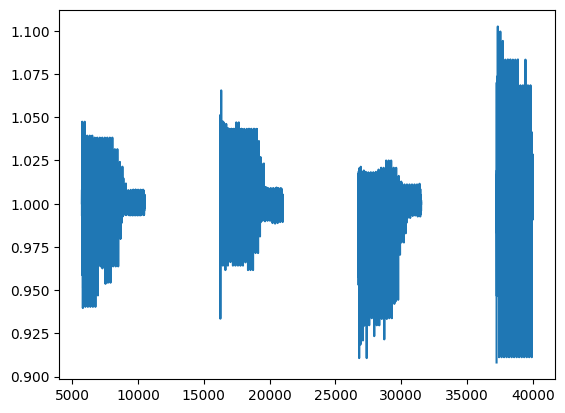

In [15]:
near_price = train["near_price"]
plot.plot(near_price[:40000])
print(f"max value: {near_price.max()}, min value: {near_price.min()}")

max value: 1.077488, min value: 0.934915


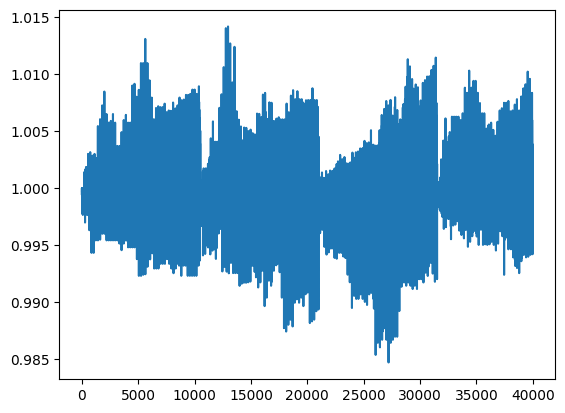

In [16]:
bid_price = train["bid_price"]
plot.plot(bid_price[:40000])
print(f"max value: {bid_price.max()}, min value: {bid_price.min()}")

max value: 1.077836, min value: 0.939827


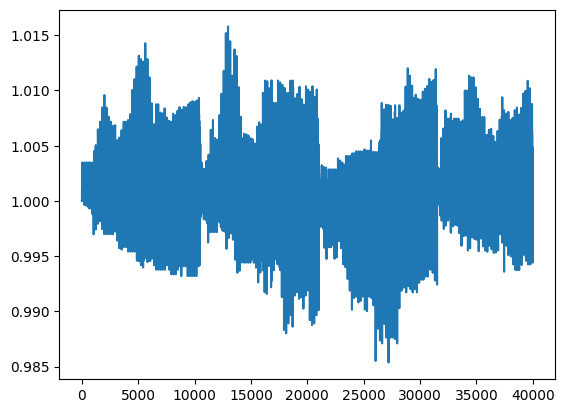

In [17]:
ask_price = train["ask_price"]
plot.plot(ask_price[:40000])
print(f"max value: {ask_price.max()}, min value: {ask_price.min()}")

max value: 30287840.0, min value: 0.56


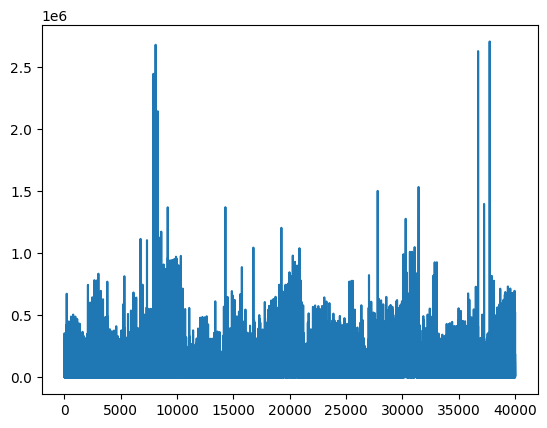

In [18]:
bid_size = train["bid_size"]
plot.plot(bid_size[:40000])
print(f"max value: {bid_size.max()}, min value: {bid_size.min()}")

max value: 54405000.0, min value: 0.59


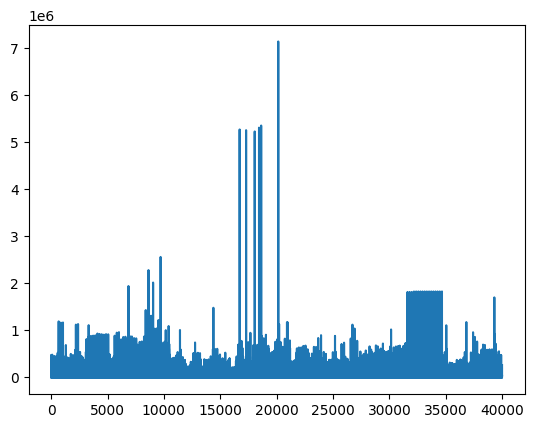

In [19]:
ask_size = train["ask_size"]
plot.plot(ask_size[:40000])
print(f"max value: {ask_size.max()}, min value: {ask_size.min()}")

max value: 1.077675, min value: 0.938008


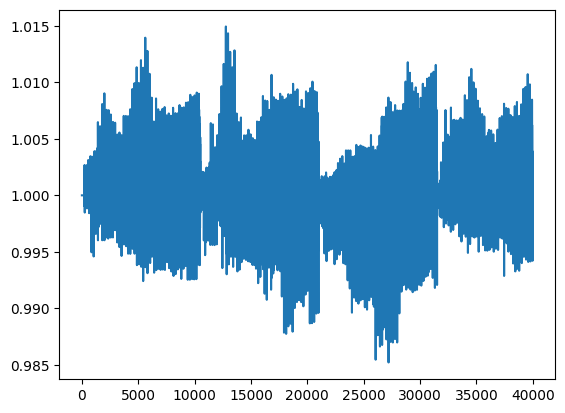

In [20]:
wap = train["wap"]
plot.plot(wap[:40000])
print(f"max value: {wap.max()}, min value: {wap.min()}")

max value: 1.077675, min value: 0.938008


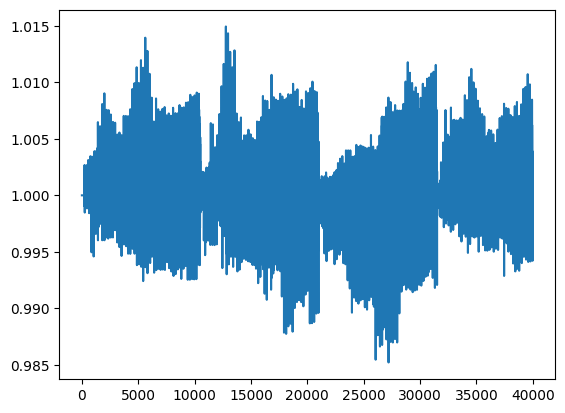

In [21]:
wap = train["wap"]
plot.plot(wap[:40000])
print(f"max value: {wap.max()}, min value: {wap.min()}")

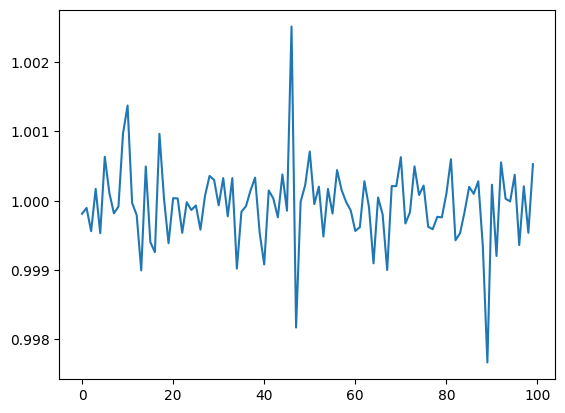

In [22]:
reference_price = train["reference_price"]
plot.plot(reference_price[:100])

In [23]:
from sklearn.neighbors import NearestNeighbors

In [24]:
train_pivot = train.pivot(index='time_id', columns='stock_id', values=["reference_price", "wap"])
train_pivot

reference_price                                                    \
stock_id             0         1         2         3         4         5     
time_id                                                                      
0               0.999812  0.999896  0.999561  1.000171  0.999532  1.000635   
1               1.000026  0.999955  0.999561  0.999870  1.000154  1.001205   
2               0.999919  0.999955  0.999351  0.999999  0.999878  1.001205   
3               1.000133  0.999896  0.999351  0.999827  0.999878  1.001287   
4               1.000455  0.999955  0.999351  1.000128  0.999878  1.001287   
...                  ...       ...       ...       ...       ...       ...   
26450           0.999017  0.996648  0.998607  0.999161  0.998590  0.998687   
26451           0.998842  0.996806  0.998607  0.999258  0.998700  0.998545   
26452           0.999193  0.996806  0.998401  0.999113  0.998645  0.998687   
26453           0.999193  0.996806  0.998246  0.999113  0.998700  0.998829   
26454           0.999193  0.996543  0.998246  0.999113  0.998700  0.998403   

                                                  ...       wap            \
stock_id       6         7         8         9    ...       190       191   
time_id                                           ...                       
0         1.000115  0.999818  0.999916  1.000969  ...  1.000000  1.000000   
1         1.000346  1.000939  0.999916  1.001130  ...  1.000016  1.001131   
2         1.000283  1.001048  1.000004  1.001453  ...  0.999987  1.001488   
3         1.000220  1.000643  0.999875  1.001291  ...  1.000892  1.001481   
4         1.000367  1.000674  0.999972  1.001614  ...  1.001050  1.001549   
...            ...       ...       ...       ...  ...       ...       ...   
26450     1.000442  0.996890  1.000673  1.000879  ...  0.999583  0.996669   
26451     1.000334  0.996636  1.000706  1.001011  ...  0.999617  0.996468   
26452     1.000172  0.996621  1.000602  1.001011  ...  0.999541  0.996107   
26453     1.000361  0.996732  1.000789  1.001011  ...  0.999529  0.996159   
26454     1.000118  0.996621  1.000927  1.001011  ...  0.999311  0.995958   

                                                                      \
stock_id       192       193       194       195       196       197   
time_id                                                                
0         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1         1.000626  0.999751  1.001251  1.000333  1.000505  0.999915   
2         1.000331  0.999653  1.001062  1.000388  1.000472  1.000050   
3         1.000461  0.999581  1.000811  1.000366  1.000268  1.000049   
4         1.000034  0.999576  1.000429  1.000773  1.000453  0.999982   
...            ...       ...       ...       ...       ...       ...   
26450     1.000558  1.001630  1.001900  1.000248  1.000740  0.996160   
26451     1.000612  1.001567  1.002025  1.000329  1.000807  0.996258   
26452     1.000542  1.001481  1.002041  1.000347  1.000815  0.996091   
26453     1.000606  1.001510  1.002040  1.000359  1.000814  0.995986   
26454     1.000698  1.001531  1.001557  1.000328  1.000819  0.995797   

                              
stock_id       198       199  
time_id                       
0         1.000000       NaN  
1         1.000222       NaN  
2         1.000401       NaN  
3         1.000429       NaN  
4         1.000523       NaN  
...            ...       ...  
26450     0.999323  1.002835  
26451     0.999321  1.002974  
26452     0.999312  1.001982  
26453     0.999028  1.001993  
26454     0.999008  1.002274  

[26455 rows x 400 columns]

In [25]:
pivot = train.pivot(index='time_id', columns='stock_id', values='reference_price')
pivot = pivot.fillna(pivot.mean())

n_max=50
nn = NearestNeighbors(n_neighbors=n_max, p=2)
nn.fit(pivot)
neighbors = nn.kneighbors(pivot)

In [26]:
dis, idx = neighbors
idx.shape

(26455, 50)

In [27]:
feature_pivot = train.pivot(index='time_id', columns='stock_id', values='reference_price')
feature_pivot = feature_pivot.fillna(feature_pivot.mean())

neighbor_features = np.zeros((n_max, *feature_pivot.shape))

for i in range(n_max):
    neighbor_features[i, :, :] += feature_pivot.values[idx[:, i], :]

In [28]:
neighbor_features.shape

(50, 26455, 200)